# 1. 거시적으로 EDA 하기  

In [ ]:
# 1. 필요한 라이브러리들 불러오기
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from src.data import CustomDataModule, CustomDataset


# 2. 프로젝트의 다른 폴더에 있는 파일을 불러오기 위한 설정
import sys
sys.path.append('..')

# 3. 데이터 모듈 불러오기
from src.data import CustomDataModule

# 4. 그래프의 한글 폰트 깨짐 방지를 위한 설정 (Mac, Windows 사용자 모두를 위해)
import platform
if platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic') 

plt.rc('axes', unicode_minus=False) # 마이너스 기호 깨짐 방지

# 5. 데이터 경로 설정
DATA_ROOT = Path('../data/raw') # notebooks 폴더 기준 상위 폴더의 data/raw

In [3]:
# 데이터 모듈을 사용해서 데이터를 준비
# 배치 사이즈나 num_workers는 EDA에서는 크게 중요하지 않음.
data_module = CustomDataModule(path=DATA_ROOT, batch_size=32, num_workers=0)

# setup() 함수만 호출하면 학습/검증 데이터 분할까지 다 알아서 함.
data_module.setup()

# 전체 학습 데이터 정보가 담긴 train_df와 meta_df를 불러오기
train_df = pd.read_csv(DATA_ROOT / 'train.csv')
meta_df = pd.read_csv(DATA_ROOT / 'meta.csv')

# 두 데이터프레임을 합쳐서 클래스 이름까지 한번에 보기
train_df = pd.merge(train_df, meta_df, left_on='target', right_on='target')
print("데이터 확인:")

display(train_df.head())

Train/Val 데이터셋 분리 및 생성 완료. Train: 1256, Val: 314
데이터 확인:


ID  target                  class_name
0  002f99746285dfdd.jpg      16  vehicle_registration_plate
1  008ccd231e1fea5d.jpg      10        payment_confirmation
2  008f5911bfda7695.jpg      10        payment_confirmation
3  009235e4c9c07af5.jpg       4                   diagnosis
4  00b2f44967580c74.jpg      16  vehicle_registration_plate

In [5]:
# print all of the class_names
print("클래스 이름들:")
print(train_df['class_name'].unique())

클래스 이름들:
['vehicle_registration_plate' 'payment_confirmation' 'diagnosis'
 'driver_lisence' 'vehicle_registration_certificate'
 'statement_of_opinion' 'passport' 'resume'
 'medical_outpatient_certificate' 'pharmaceutical_receipt' 'car_dashboard'
 'national_id_card' 'prescription'
 'confirmation_of_admission_and_discharge' 'account_number'
 'application_for_payment_of_pregnancy_medical_expenses'
 'medical_bill_receipts']


In [7]:
# 원본 영어 class_name을 'class_name_eng'로 백업
train_df['class_name_eng'] = train_df['class_name']

# 한글 이름 매핑
class_name_mapping = {
    'vehicle_registration_plate': '차량번호판',
    'payment_confirmation': '결제확인서',
    'diagnosis': '진단서',
    'driver_lisence': '운전면허증',
    'vehicle_registration_certificate': '자동차등록증',
    'statement_of_opinion': '의견서',
    'passport': '여권',
    'resume': '이력서',
    'medical_outpatient_certificate': '외래진료확인서',
    'pharmaceutical_receipt': '약국영수증',
    'car_dashboard': '자동차계기판',
    'national_id_card': '주민등록증',
    'prescription': '처방전',
    'confirmation_of_admission_and_discharge': '입퇴원확인서',
    'account_number': '계좌번호',
    'application_for_payment_of_pregnancy_medical_expenses': '임신진료비신청서',
    'medical_bill_receipts': '진료비영수증'
}

# 정렬된 클래스명에 번호 붙이기
sorted_classes = sorted(class_name_mapping.keys())
index_ko_mapping = {
    class_name: f"{str(idx).zfill(2)}_{class_name_mapping[class_name]}"
    for idx, class_name in enumerate(sorted_classes)
}

# class_label 생성
train_df['class_label'] = train_df['class_name'].map(index_ko_mapping)
train_df

ID  target                      class_name  \
0     002f99746285dfdd.jpg      16      vehicle_registration_plate   
1     008ccd231e1fea5d.jpg      10            payment_confirmation   
2     008f5911bfda7695.jpg      10            payment_confirmation   
3     009235e4c9c07af5.jpg       4                       diagnosis   
4     00b2f44967580c74.jpg      16      vehicle_registration_plate   
...                    ...     ...                             ...   
1565  fed9e9ec4a77bc06.jpg       4                       diagnosis   
1566  feeade617aa68c45.jpg       7  medical_outpatient_certificate   
1567  ff51dd281a8423f1.jpg      11          pharmaceutical_receipt   
1568  ff8a6a251ce51c95.jpg       5                  driver_lisence   
1569  ffc22136f958deb1.jpg       9                        passport   

                      class_name_eng class_label  
0         vehicle_registration_plate    16_차량번호판  
1               payment_confirmation    10_결제확인서  
2               payment_confirmation    10_결제확인서  
3                          diagnosis      04_진단서  
4         vehicle_registration_plate    16_차량번호판  
...                              ...         ...  
1565                       diagnosis      04_진단서  
1566  medical_outpatient_certificate  07_외래진료확인서  
1567          pharmaceutical_receipt    11_약국영수증  
1568                  driver_lisence    05_운전면허증  
1569                        passport       09_여권  

[1570 rows x 5 columns]

/var/folders/6n/kfklly_d5_n7twg5np_7c7pr0000gn/T/ipykernel_52111/1737582989.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.values, y=class_counts.index, palette='viridis', orient='h')


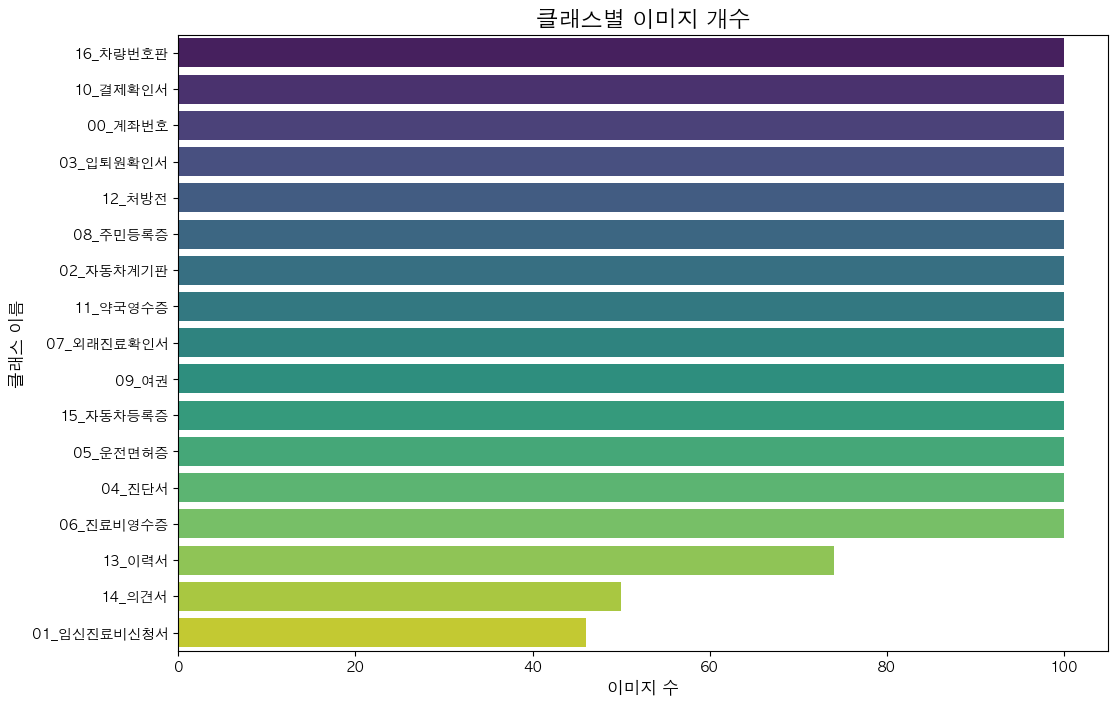

In [8]:
# 클래스별 이미지 개수 세기
class_counts = train_df['class_label'].value_counts()

# 막대그래프로 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x=class_counts.values, y=class_counts.index, palette='viridis', orient='h')
plt.title('클래스별 이미지 개수', fontsize=16)
plt.xlabel('이미지 수', fontsize=12)
plt.ylabel('클래스 이름', fontsize=12)
plt.show()

1, 13, 14번이 이미지 개수가 적다.

나머지는 모두 100개씩 동일한 개수이다.

/var/folders/6n/kfklly_d5_n7twg5np_7c7pr0000gn/T/ipykernel_52111/3074992050.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.values, y=class_counts.index, palette='viridis', orient='h')


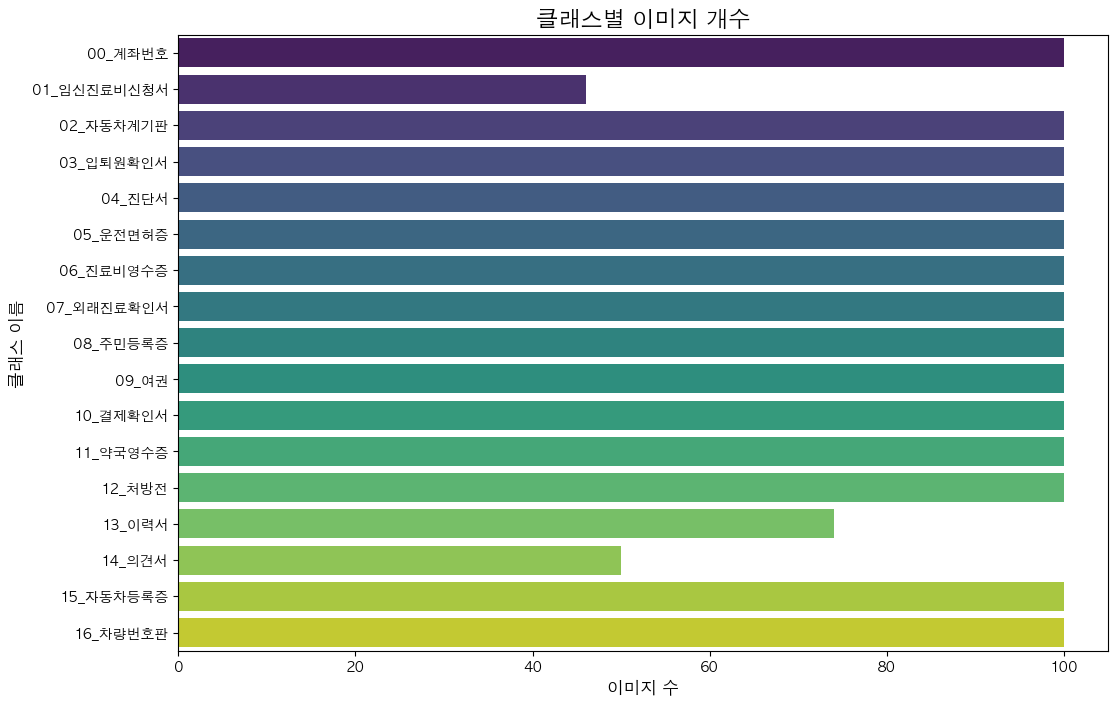

In [9]:
# 클래스별 이미지 개수 세기
class_counts = train_df['class_label'].value_counts()

# 라벨(인덱스)을 오름차순으로 정렬
class_counts = class_counts.sort_index()

# 막대그래프로 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x=class_counts.values, y=class_counts.index, palette='viridis', orient='h')
plt.title('클래스별 이미지 개수', fontsize=16)
plt.xlabel('이미지 수', fontsize=12)
plt.ylabel('클래스 이름', fontsize=12)
plt.show()


In [10]:
# 이미지 크기를 저장할 리스트
widths, heights = [], []

# train 폴더에 있는 모든 이미지 경로 가져오기
image_paths = list((DATA_ROOT / 'train').glob('*.jpg'))

# 각 이미지의 크기 정보 읽어오기 
for path in image_paths:
    with Image.open(path) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

# 데이터프레임으로 만들기
size_df = pd.DataFrame({'width': widths, 'height': heights})
print("이미지 크기 통계:")
display(size_df.describe())

이미지 크기 통계:


width       height
count  1570.000000  1570.000000
mean    497.613376   538.169427
std      79.370316    76.074772
min     384.000000   348.000000
25%     443.000000   443.000000
50%     443.000000   591.000000
75%     591.000000   591.000000
max     753.000000   682.000000

# 이미지 크기 통계

1. 세로가 가로보다 길다 --> 문서들이 대체로 세로형 문서가 많다
2.  가로(width)의 25% 지점과 50% 지점(중앙값)이 443으로 같은데,'특정 규격(A4 비율 등)의 문서'가 데이터셋에 아주 많은걸로 추정됨  

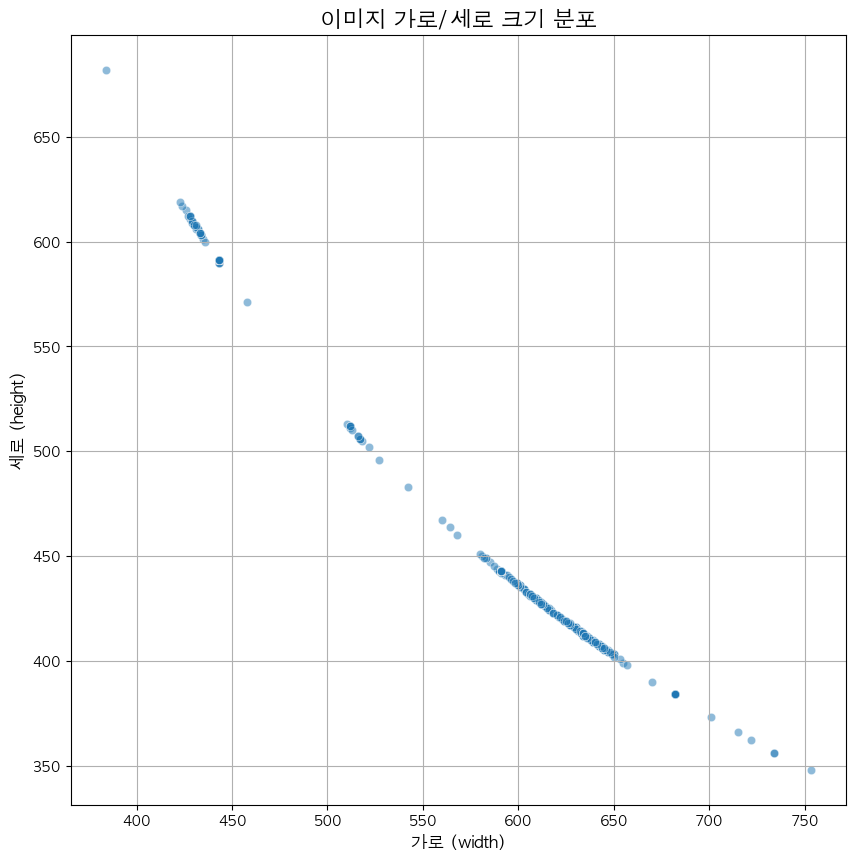

In [12]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=size_df, x='width', y='height', alpha=0.5)
plt.title('이미지 가로/세로 크기 분포', fontsize=16)
plt.xlabel('가로 (width)', fontsize=12)
plt.ylabel('세로 (height)', fontsize=12)
plt.grid(True)
plt.show()

##  이미지 분포  
엑스축: 이미지 가로, 와이축: 이미지 세로 길이 

1. 그래프가 우하향 --> 가로와 세로의 비율이 비슷한 이미지들이 많다는 의미!!
- 그래서 군집처럼 보임

2. 가로-세로 비율로 여권, 에이포용지 등등으로 추론 가능할듯!

# 2. 미시적 분석하기 

이미지 크기 통계:
--- 훈련 데이터셋(Train Set) 이미지 샘플 ---


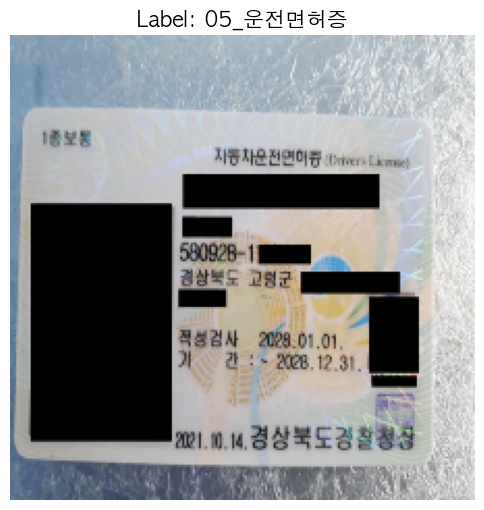

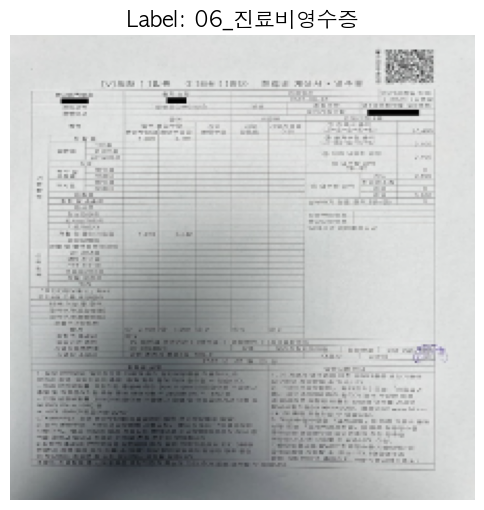

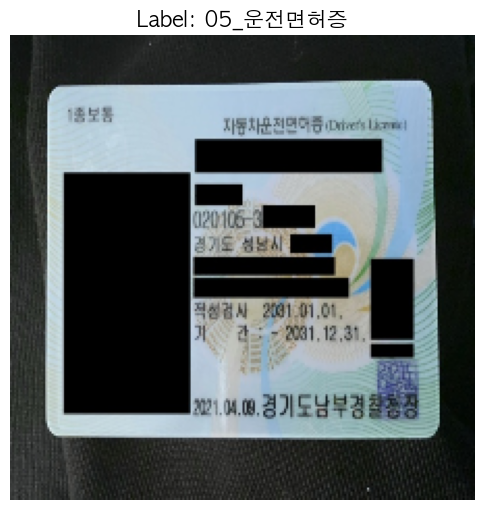

In [ ]:
''' 훈련 데이터 몇개 살펴보기 '''

# 이미지 시각화를 위한 헬퍼 함수
def visualize_image(tensor_image, title=""):
    # 텐서를 CPU로 옮기고 NumPy 배열로 변환
    img_np = tensor_image.cpu().numpy()
    
    # 채널 차원을 마지막으로 이동 (C, H, W) -> (H, W, C)
    img_np = np.transpose(img_np, (1, 2, 0))
    
    # 정규화 되돌리기 (Denormalization)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1) # 값을 0과 1 사이로 유지
    
    # 이미지 출력
    plt.figure(figsize=(6, 8))
    plt.imshow(img_np)
    plt.title(title, fontsize=15)
    plt.axis('off') # 축 정보는 숨기기
    plt.show()

print("이미지 크기 통계:")

# data_module에서 학습용 데이터셋(train_dataset) 가져오기
train_dataset = data_module.train_dataset

print("--- 훈련 데이터셋(Train Set) 이미지 샘플 ---")

# 3개의 이미지를 무작위로 뽑아서 시각화
for _ in range(3):
    random_idx = np.random.randint(0, len(train_dataset))
    image, label_idx = train_dataset[random_idx]
    
    # class_label을 사용해서 한글 클래스 이름 가져오기
    # train_df는 이전 단계에서 이미 로드했으므로 바로 사용 가능
    class_name = train_df[train_df['target'] == label_idx]['class_label'].iloc[0]
    
    visualize_image(image, title=f"Label: {class_name}")


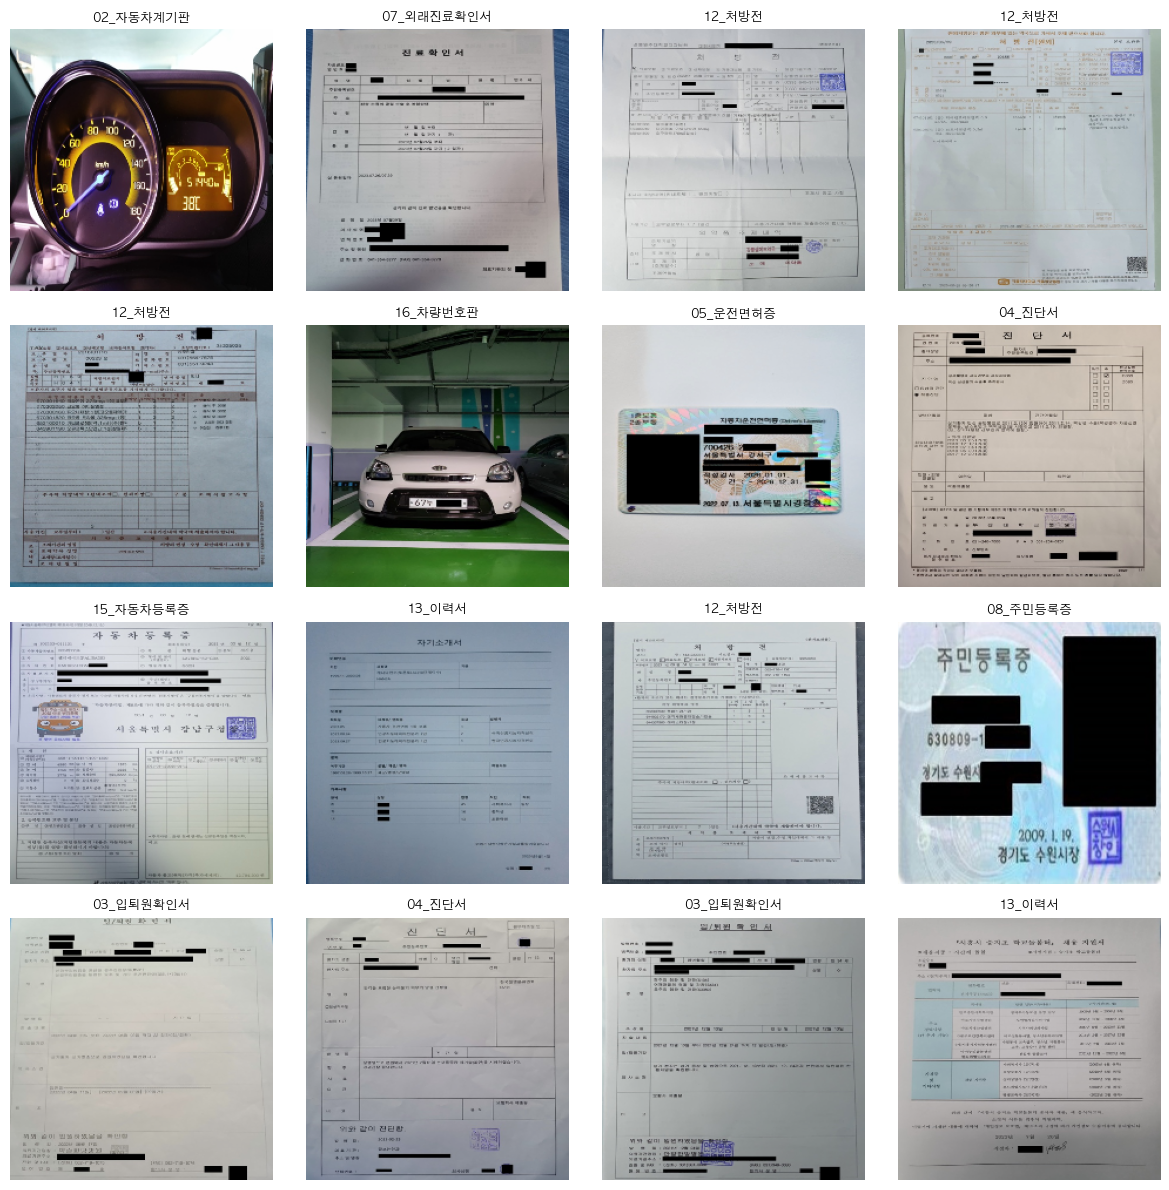

In [16]:
# 이미지 시각화를 위한 헬퍼 함수 (16장 출력용)
def visualize_images_grid(dataset, df, num_images=16, grid_size=(4, 4)):
    """
    주어진 데이터셋에서 num_images 개의 이미지를 무작위로 선택해 grid 형태로 시각화합니다.
    """
    plt.figure(figsize=(12, 12))  # 전체 figure 크기
    for i in range(num_images):
        random_idx = np.random.randint(0, len(dataset))
        image, label_idx = dataset[random_idx]

        # 텐서를 NumPy로 변환 (정규화 되돌리기)
        img_np = image.cpu().numpy()
        img_np = np.transpose(img_np, (1, 2, 0))  # (C,H,W) -> (H,W,C)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)

        # 클래스 이름 가져오기
        class_name = df[df['target'] == label_idx]['class_label'].iloc[0]

        # 서브플롯으로 이미지 추가
        ax = plt.subplot(grid_size[0], grid_size[1], i + 1)
        ax.imshow(img_np)
        ax.set_title(class_name, fontsize=9)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# 실행
visualize_images_grid(train_dataset, train_df)

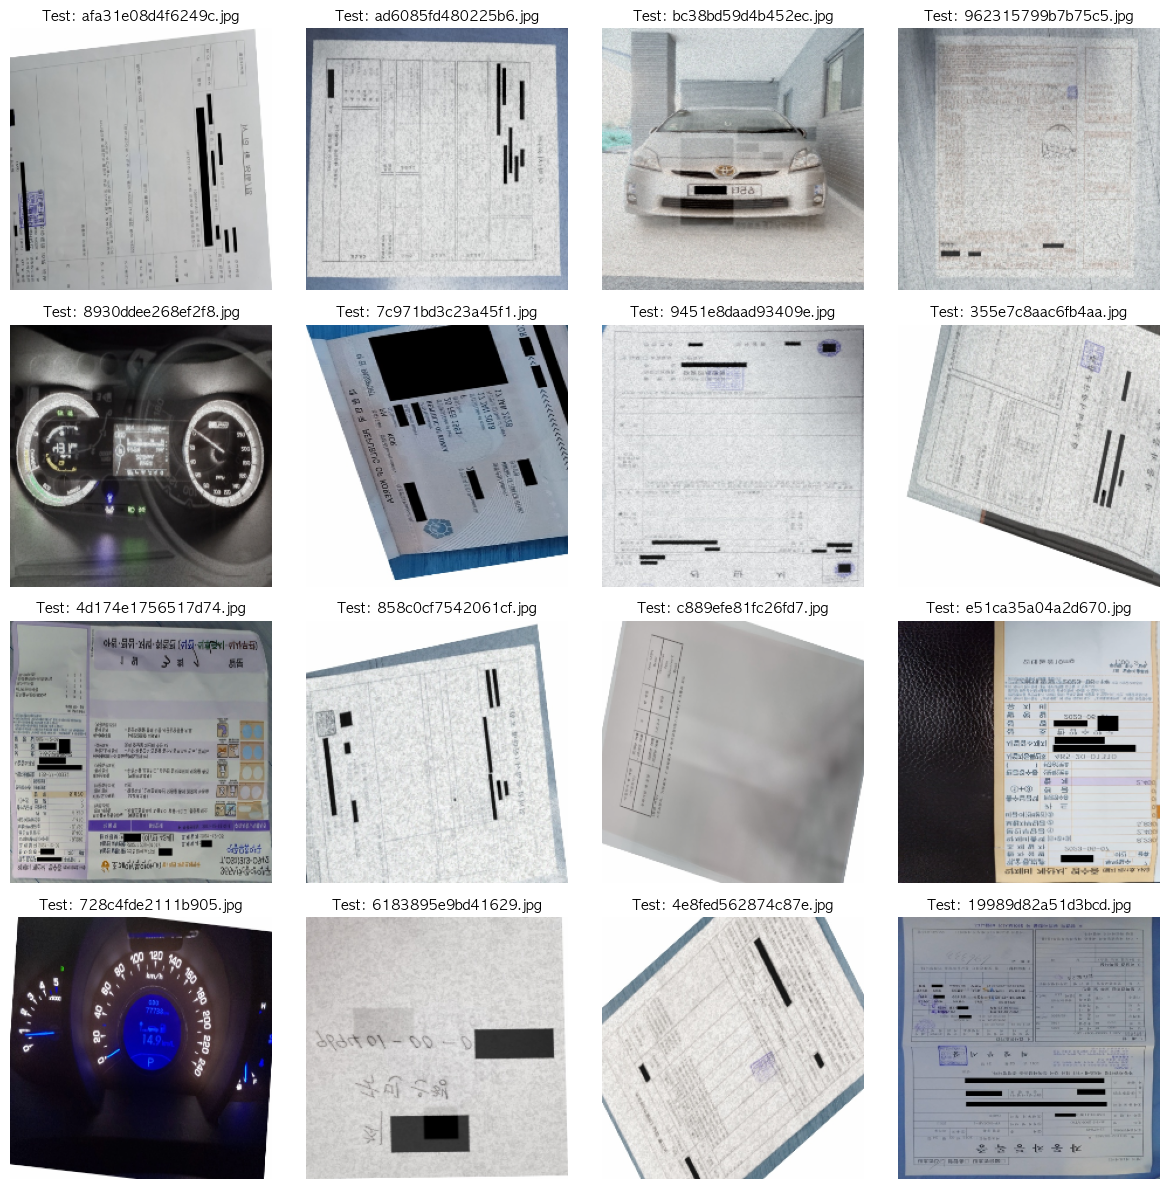

In [22]:
from pathlib import Path
# 16장의 이미지를 4x4 격자로 시각화하는 함수
def visualize_images_grid(images, titles=None, n_rows=4, n_cols=4):
    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    
    for i in range(len(images)):
        img_np = images[i].cpu().numpy()
        img_np = np.transpose(img_np, (1, 2, 0))
        
        # Denormalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img_np)
        if titles:
            plt.title(titles[i], fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 테스트 데이터 정보 로딩 및 임시 라벨 추가
test_info_df = pd.read_csv(DATA_ROOT / 'sample_submission.csv')
test_info_df['target'] = 0

# 테스트용 데이터셋 생성
test_dataset = CustomDataset(
    df=test_info_df,
    data_root=DATA_ROOT / 'test',
    transform=data_module.transform
)


# 16장 무작위 선택
images = []
titles = []

for _ in range(16):
    random_idx = np.random.randint(0, len(test_dataset))
    image, _ = test_dataset[random_idx]
    images.append(image)

    # 이미지 파일 이름만 추출 (Path 객체로 변환한 후 name 속성 사용)
    image_path = Path(test_dataset.image_paths[random_idx])
    image_id = image_path.name
    titles.append(f"Test: {image_id}")

# 시각화
visualize_images_grid(images, titles)

## 테스트 데이터 보고 느낀점

1. 문서 유형 다양한데 섞여 있다.
2. 이미지 방향이 제각각이다 --> 회전 교정 무조건 하자
3. 해상도, 색감, 품질이 가지각색이다.
4. 사진에 테두리 배경이 있는 것도 있고, 없는것도 있다. (Document Detection + Crop 적용도 고려할 수 있음)
5. 검열 처리된 마스크(privacy masking)이 있는 문서가 있다
6. 여권, 처방전, 입원확인서등은 OCR 추출이 유용할 수 있다
7. 데이터 증강 시 방향/비율 유지가 중요



## 아이디어
1. 데이터 전처리 단계에서 회전 보정, 디노이징, 배경 제거, 비율 유지 padding이 매우 중요
2. 클래스 구분 기준이 이미지의 전체 모양(레이아웃) + 문서의 종류 + 글자 스타일 등이므로 복합적 시각 정보 학습이 필요
3. 일부 클래스(운전면허증, 계기판 등)는 이미지 스타일 자체가 독특하여 특화된 서브 모델 or 앙상블 모델로 접근 가능

# 3. 클래스별 특징 살펴보자 

In [23]:
# 1. 특징 추출을 위한 모델 로드
import timm
import torch
from tqdm.auto import tqdm

# GPU가 있다면 사용하고, 없다면 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ImageNet으로 사전학습된 efficientnet_b0 모델을 불러오되,
# 마지막 분류 레이어는 제외하고 특징 추출기(feature extractor)로만 사용
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0).to(device)
model.eval() # 평가 모드로 설정

# 2. 시각화를 위한 추가 라이브러리
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore') # 자잘한 경고 무시

print(f"특징 추출을 위한 모델({model.default_cfg['architecture']}) 준비 완료. 실행 디바이스: {device}")

특징 추출을 위한 모델(efficientnet_b0) 준비 완료. 실행 디바이스: cpu


In [24]:
''' 모든 이미지의 특징 벡터 추출하기'''

# data_module과 train_df는 이전 EDA 단계에서 이미 로드했다고 가정
# 만약 노트북을 새로 켰다면 이전 단계 코드를 다시 실행해야 해

feature_list = []
label_list = []

# DataLoader를 만들어서 배치 단위로 처리하면 더 빠르지만,
# 여기서는 이해하기 쉽게 한 장씩 처리
print("모든 훈련 이미지의 특징 벡터를 추출합니다... (시간 소요)")

for image, label in tqdm(data_module.train_dataset):
    # 이미지를 모델이 있는 디바이스로 보내고, 배치 차원 추가
    image = image.unsqueeze(0).to(device)

    with torch.no_grad(): # 그래디언트 계산 비활성화
        feature = model(image)

    feature_list.append(feature.cpu().numpy().flatten())
    label_list.append(label)

feature_df = pd.DataFrame(feature_list)
feature_df['target'] = label_list
print("특징 벡터 추출 완료!")

모든 훈련 이미지의 특징 벡터를 추출합니다... (시간 소요)


  0%|          | 0/1256 [00:00<?, ?it/s]

특징 벡터 추출 완료!


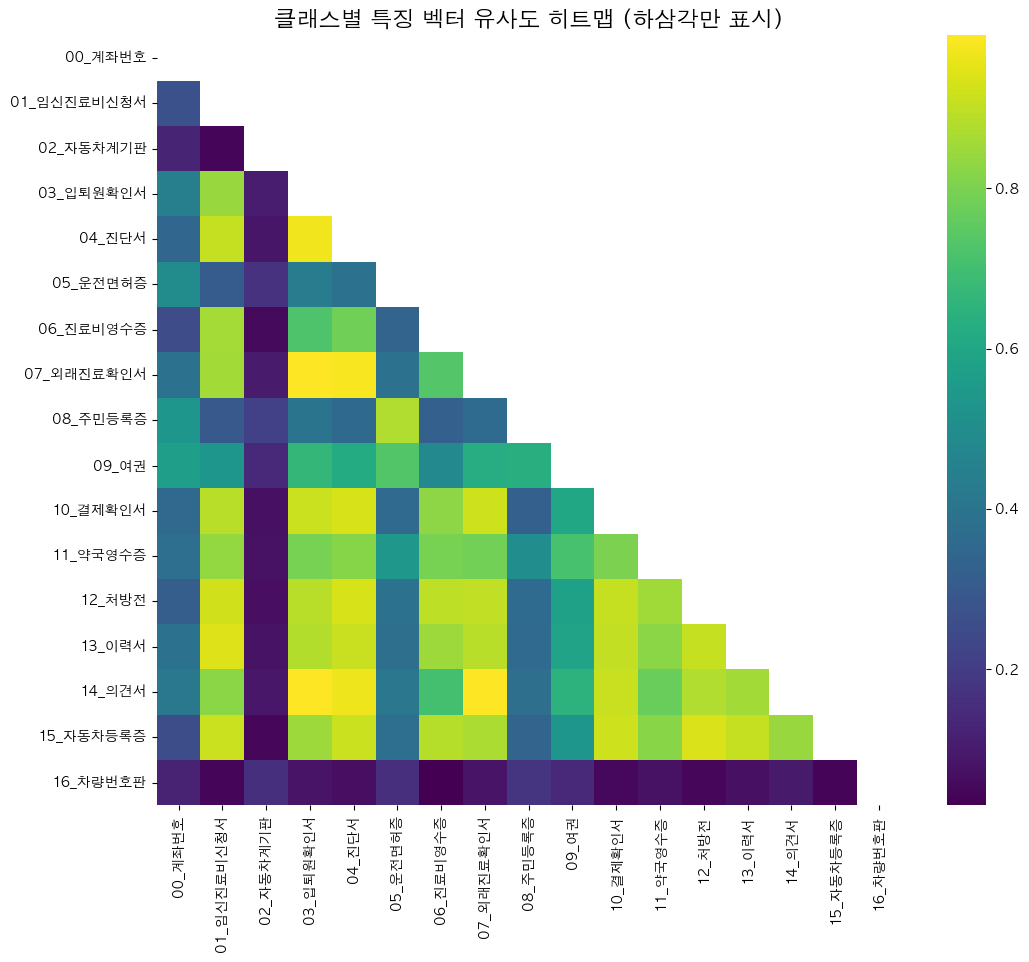

In [ ]:
''' 클래스별 평균 특징 계산, 유사도를 시각화 해보자해보자 '''

# 클래스별 평균 특징 벡터 계산
mean_features = feature_df.groupby('target').mean()

# 한글 클래스 이름과 매핑
mean_features = pd.merge(mean_features, meta_df, left_index=True, right_on='target')
mean_features = pd.merge(mean_features, pd.DataFrame(index_ko_mapping.items(), columns=['class_name', 'class_label']), on='class_name')
mean_features = mean_features.set_index('class_label').drop(columns=['target', 'class_name'])

# 코사인 유사도 계산
similarity_matrix = cosine_similarity(mean_features)

# 히트맵에 사용할 마스크 만들기 (상삼각만 True)
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

# 히트맵으로 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix, annot=False, cmap='viridis',
            xticklabels=mean_features.index,
            yticklabels=mean_features.index,
            mask=mask)  # 마스크 적용
plt.title('클래스별 특징 벡터 유사도 히트맵 (하삼각만 표시)', fontsize=16)
plt.show()

## 히트맵 해석

1. 노란색에 가까울수록 모델이 헷갈려하는 유사도가 높은 클래스다
 

In [ ]:
''' 그림으로 보니까 노란색 찾기 귀찮아서 수치 기반으로 코드 다시 짬 '''

# DataFrame으로 변환해서 클래스 이름이 인덱스가 되게 함
similarity_df = pd.DataFrame(similarity_matrix,
                             index=mean_features.index,
                             columns=mean_features.index)

# 각 클래스별로 가장 유사한 (자기 자신 제외) 클래스 찾기
for class_name in similarity_df.index:
    most_similar = similarity_df.loc[class_name].drop(class_name).idxmax()
    score = similarity_df.loc[class_name].drop(class_name).max()
    print(f"{class_name} → 가장 유사한 클래스: {most_similar} (유사도: {score:.3f})")

00_계좌번호 → 가장 유사한 클래스: 09_여권 (유사도: 0.564)
01_임신진료비신청서 → 가장 유사한 클래스: 13_이력서 (유사도: 0.942)
02_자동차계기판 → 가장 유사한 클래스: 08_주민등록증 (유사도: 0.212)
03_입퇴원확인서 → 가장 유사한 클래스: 07_외래진료확인서 (유사도: 0.991)
04_진단서 → 가장 유사한 클래스: 07_외래진료확인서 (유사도: 0.981)
05_운전면허증 → 가장 유사한 클래스: 08_주민등록증 (유사도: 0.876)
06_진료비영수증 → 가장 유사한 클래스: 12_처방전 (유사도: 0.896)
07_외래진료확인서 → 가장 유사한 클래스: 03_입퇴원확인서 (유사도: 0.991)
08_주민등록증 → 가장 유사한 클래스: 05_운전면허증 (유사도: 0.876)
09_여권 → 가장 유사한 클래스: 05_운전면허증 (유사도: 0.729)
10_결제확인서 → 가장 유사한 클래스: 04_진단서 (유사도: 0.932)
11_약국영수증 → 가장 유사한 클래스: 12_처방전 (유사도: 0.853)
12_처방전 → 가장 유사한 클래스: 15_자동차등록증 (유사도: 0.937)
13_이력서 → 가장 유사한 클래스: 01_임신진료비신청서 (유사도: 0.942)
14_의견서 → 가장 유사한 클래스: 07_외래진료확인서 (유사도: 0.990)
15_자동차등록증 → 가장 유사한 클래스: 12_처방전 (유사도: 0.937)
16_차량번호판 → 가장 유사한 클래스: 08_주민등록증 (유사도: 0.178)


## 유사도 보고 느낀점 정리 

1. 고위험군 (99% 비슷)
- `03_입퇴원확인서` ↔ `07_외래진료확인서` (0.991) 
- `14_의견서` → `07_외래진료확인서` (0.990)
- `04_진단서` → `07_외래진료확인서` (0.981)

2. 전혀 달라보이는데, 비슷하게 나온것들
- `01_임신진료비신청서` ↔ `13_이력서` (0.942)
- `12_처방전` ↔ `15_자동차등록증` (0.937)

3. 예상했던대로 비슷했던 것들
- `05_운전면허증` ↔ `08_주민등록증` (0.876)
- `06_진료비영수증` → `12_처방전` (0.896)

# 4. 트레인-테스트 비교하기 

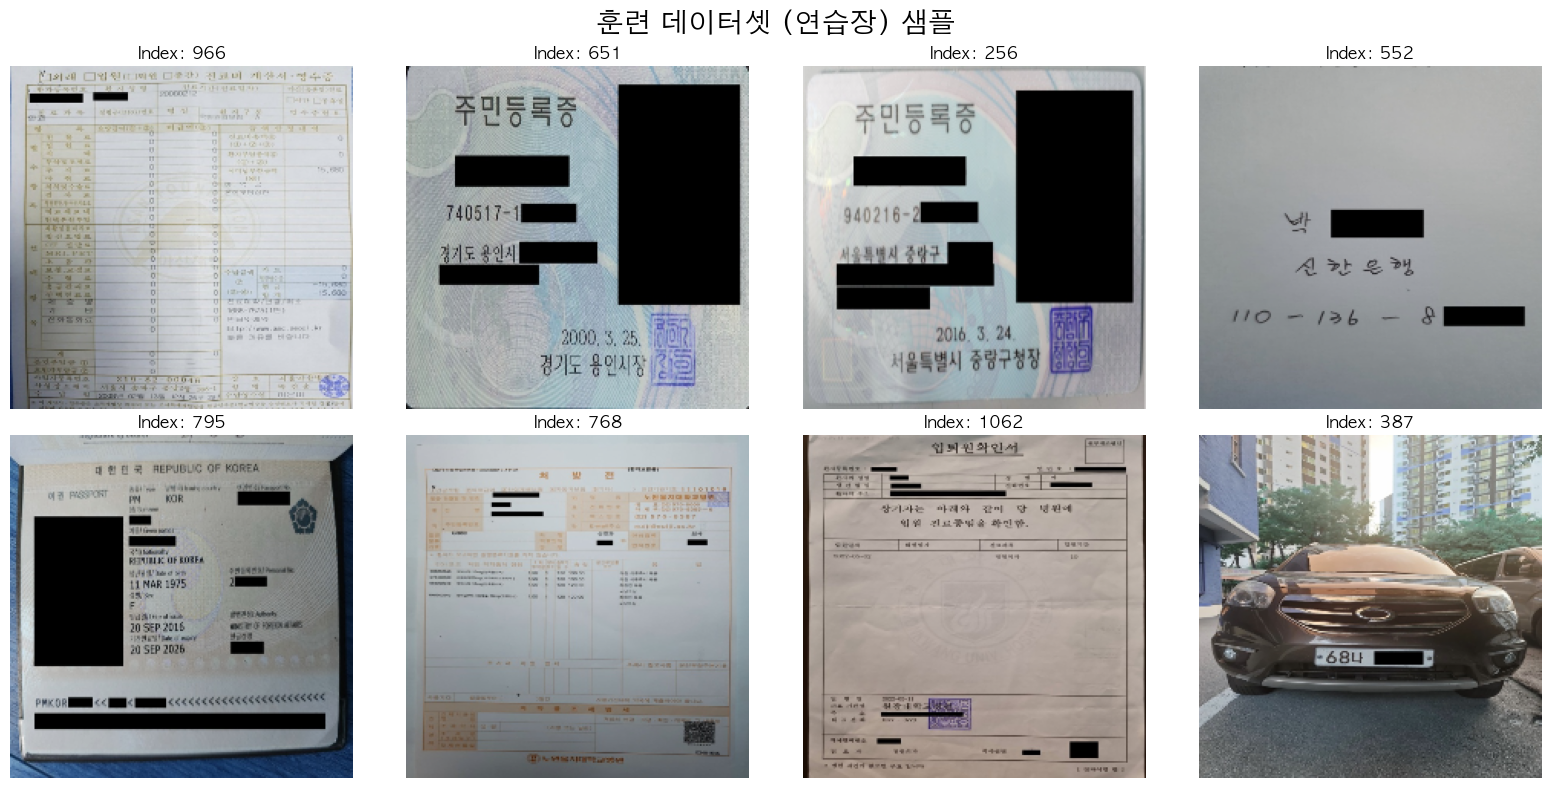

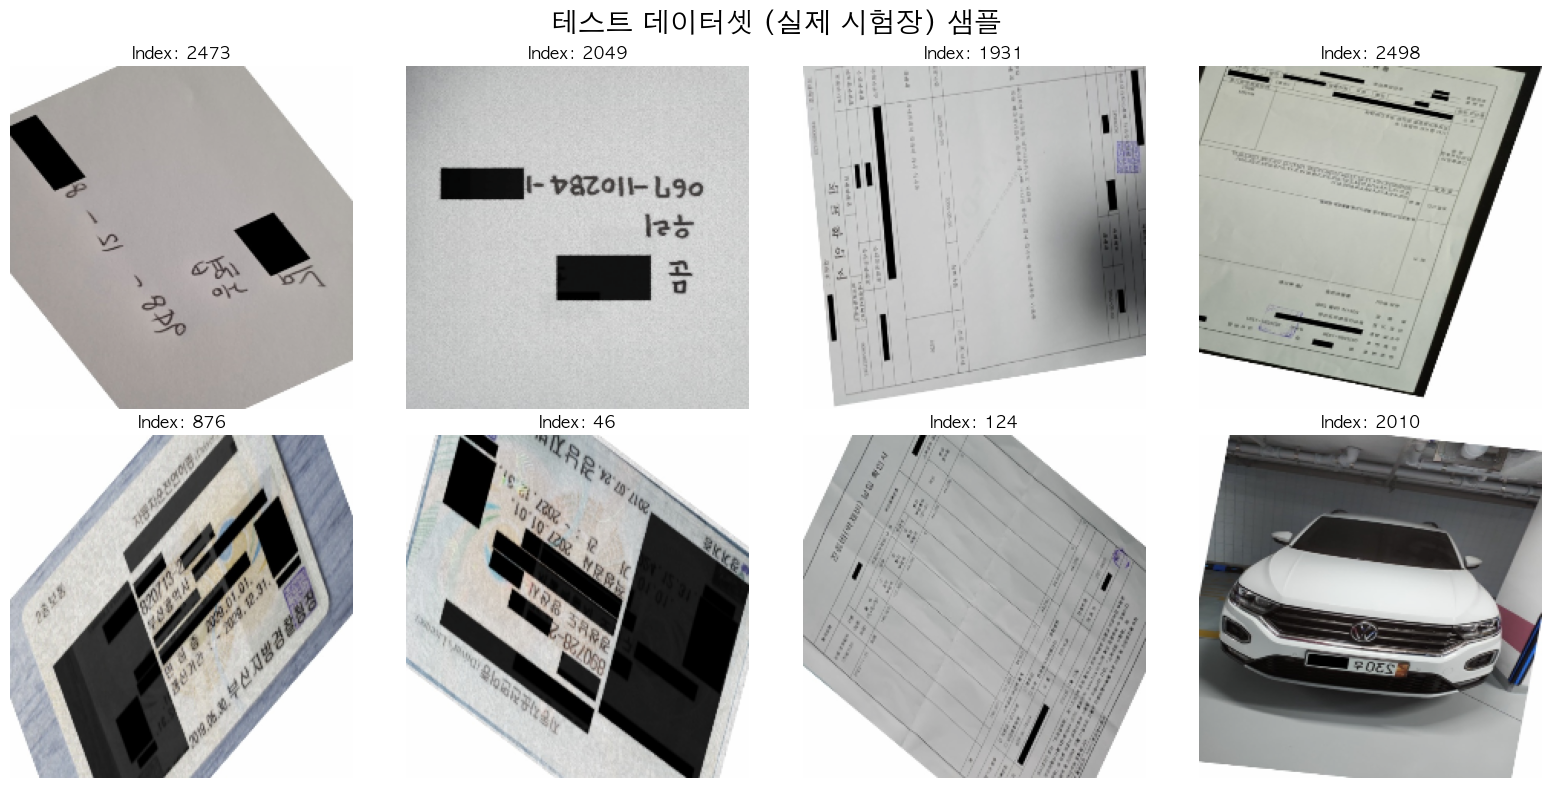

In [28]:
''' 노이즈 레벨 비교하기'''

# 이전 EDA 단계에서 만든 train_dataset과 test_dataset을 그대로 사용.
def plot_image_grid(dataset, indices, title):
    """
    주어진 데이터셋과 인덱스 리스트에 해당하는 이미지를 격자 형태로 시각화합니다.
    """
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(title, fontsize=20)
    axes = axes.flatten()
    for i, idx in enumerate(indices):
        image, label = dataset[idx] # 라벨은 사용하지 않더라도 받아줘야 함
        img_np = image.cpu().numpy()
        img_np = np.transpose(img_np, (1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        
        axes[i].imshow(img_np)
        axes[i].set_title(f"Index: {idx}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# 훈련셋과 테스트셋에서 각각 8개의 이미지를 무작위로 뽑기
train_indices = np.random.choice(len(train_dataset), 8, replace=False)
test_indices = np.random.choice(len(test_dataset), 8, replace=False)

# 시각화시각화 
plot_image_grid(train_dataset, train_indices, "훈련 데이터셋 (연습장) 샘플")
plot_image_grid(test_dataset, test_indices, "테스트 데이터셋 (실제 시험장) 샘플")

## 느낀점

1. 훈련 데이터는 깨끗, 테스트 데이터는 회전등 노이즈가 많군..
 

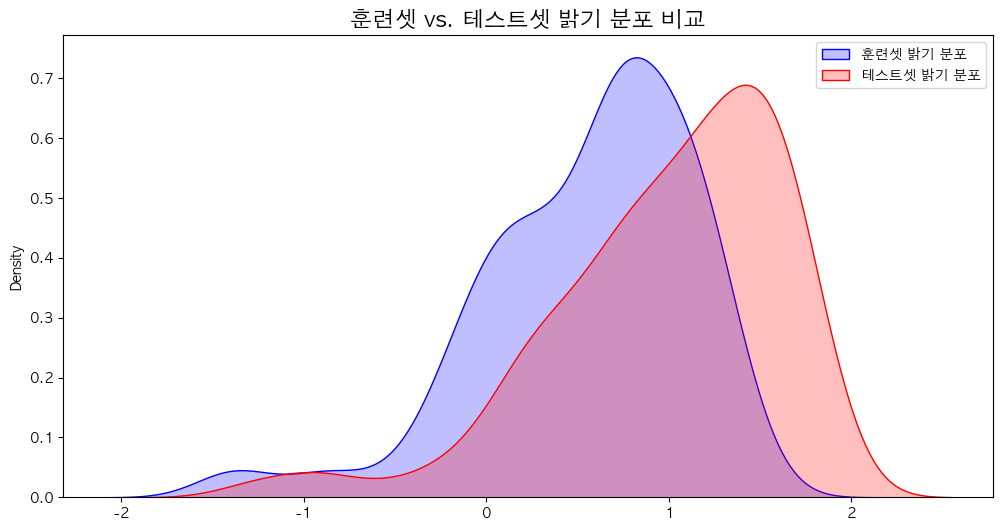

In [29]:
''' 밝기/ 대비 분포 비교하기'''

# 각 이미지의 평균 밝기를 계산하는 함수
def get_brightness(image_tensor):
    return image_tensor.mean().item()

# 훈련셋과 테스트셋에서 각각 300개의 샘플만 뽑아서 밝기 계산 (속도를 위해)
train_brightness = [get_brightness(train_dataset[i][0]) for i in np.random.choice(len(train_dataset), 300)]
test_brightness = [get_brightness(test_dataset[i][0]) for i in np.random.choice(len(test_dataset), 300)]

# KDE(커널 밀도 추정) 그래프로 분포 시각화
plt.figure(figsize=(12, 6))
sns.kdeplot(train_brightness, label='훈련셋 밝기 분포', color='blue', fill=True)
sns.kdeplot(test_brightness, label='테스트셋 밝기 분포', color='red', fill=True)
plt.title('훈련셋 vs. 테스트셋 밝기 분포 비교', fontsize=16)
plt.legend()
plt.show()

## 밝기 분포 비교

1. 훈련셋, 테스트 셋의 밝기 분포가 다름
- 테스트셋이 좀 더 밝음

2.  해결방안
- 훈련셋 밝기 다양화 시키기
- 훈련/데이터 셋을 놀멀라이즈 시키기 
- 밝기 기반 도메인 적용

모든 테스트 이미지의 특징 벡터를 추출합니다... (시간 소요)


  0%|          | 0/3140 [00:00<?, ?it/s]

  0%|          | 0/3140 [00:00<?, ?it/s]


--- 숨겨진 함정? 가장 이질적인 테스트 이미지들 ---


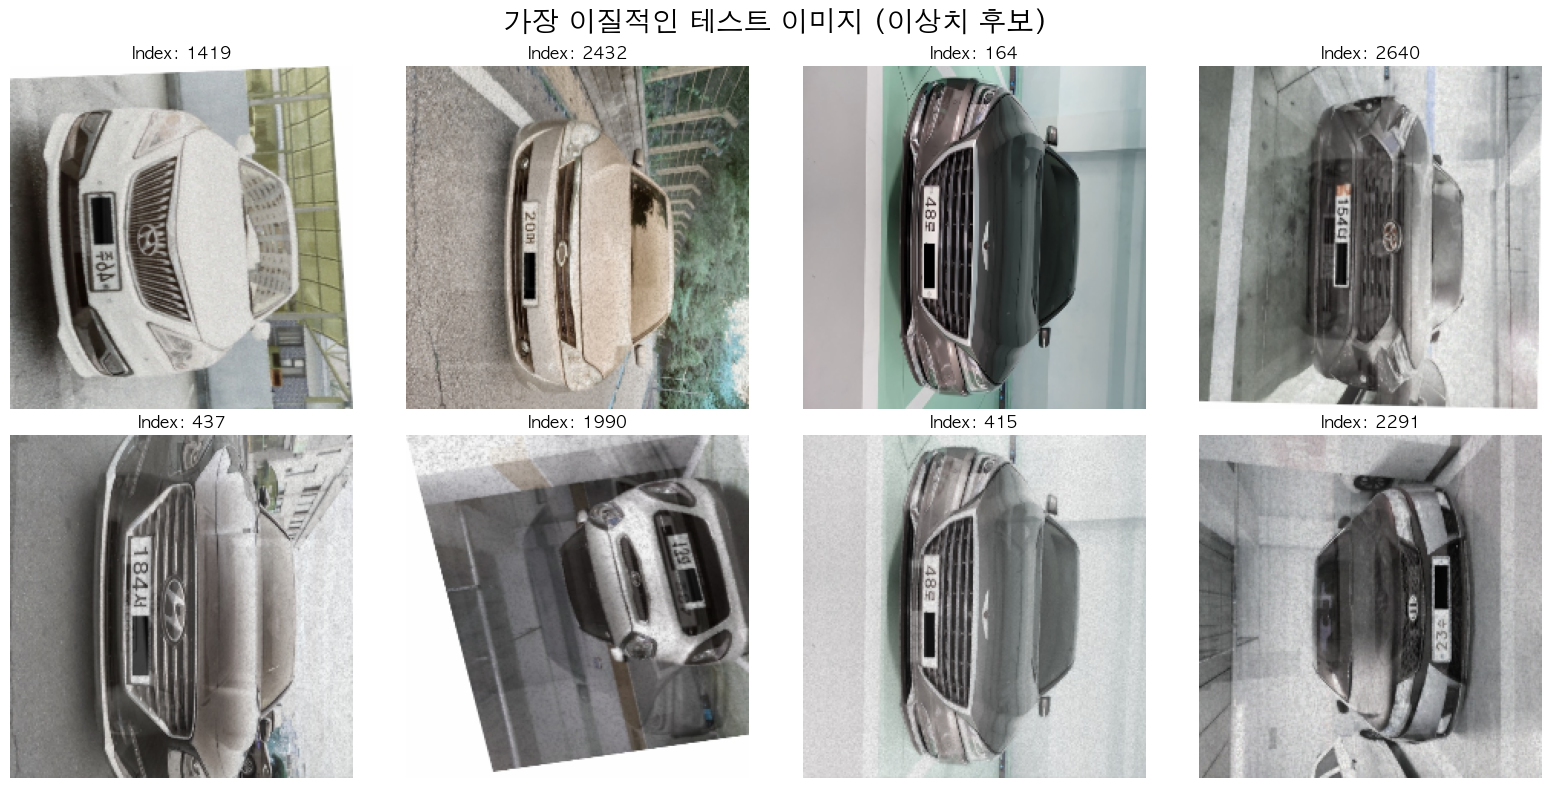

In [ ]:
# 이상치 탐지
'''테스트셋 이미지 중에서 훈련셋의 모든 클래스 평균과 비교했을 때 
가장 유사하지 않은(이질적인) 이상치 이미지 찾기'''

# 1단계: 테스트셋의 특징 벡터 추출 
test_feature_list = []
print("모든 테스트 이미지의 특징 벡터를 추출합니다... (시간 소요)")

for image, _ in tqdm(test_dataset):
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        feature = model(image)
    test_feature_list.append(feature.cpu().numpy().flatten())

# 2단계: 각 테스트 이미지가 훈련셋의 모든 클래스와 얼마나 다른지 계산
min_distances = []
for test_vec in tqdm(test_feature_list):
    # 각 훈련 클래스 평균 벡터와의 거리를 모두 계산
    distances = 1 - cosine_similarity(test_vec.reshape(1, -1), mean_features.values)
    # 그 중 가장 가까운 클래스와의 거리를 저장
    min_distances.append(distances.min())

# 3단계: 가장 이질적인(거리가 먼) 상위 8개 이미지 찾기
outlier_indices = np.argsort(min_distances)[-8:] # 거리가 가장 먼 8개의 인덱스

print("\n--- 숨겨진 함정? 가장 이질적인 테스트 이미지들 ---")
plot_image_grid(test_dataset, outlier_indices, "가장 이질적인 테스트 이미지 (이상치 후보)")

## 느낀점

1. 노이즈, 뿌연 효과가 있다
2. 
3. 차량이 전부 완전히 나온게 아니라 조금 잘려있는 사진도 있다
4. 중복/ 혼합된것처럼 보이는 사진도 있음 

# 250702

# 1. 해상도에 대해 먼저 파악 -> 회전 교정 8방향으로 하기

In [36]:
import pandas as pd
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 경로 설정
DATA_DIR = '../data/raw' 
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train')

# 학습 데이터 정보 로드
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
image_files = train_df['ID'].tolist()

print(f"총 분석할 이미지 개수: {len(image_files)}개")

총 분석할 이미지 개수: 1570개


In [ ]:
widths = []
heights = []

# tqdm을 사용해서 진행 상황 확인
for file_name in tqdm(image_files, desc="해상도 정보 수집 중"):
    # 이미지 파일 경로
    img_path = os.path.join(TRAIN_IMG_DIR, file_name)
    
    # OpenCV로 이미지 읽기
    image = cv2.imread(img_path)
    
    if image is not None:
        # 이미지의 세로(height), 가로(width) 정보 추출
        h, w, _ = image.shape
        widths.append(w)
        heights.append(h)

# 분석하기 편하게 DataFrame으로 만들기
resolution_df = pd.DataFrame({
    'filename': image_files,
    'width': widths,
    'height': heights
})

print("\n수집 완료! 해상도 정보 미리보기:")
print(resolution_df.head())

In [37]:
''' 모든 이미지의 해상도 정보 수집하기 '''

widths = []
heights = []

# tqdm을 사용해서 진행 상황 확인
for file_name in tqdm(image_files, desc="해상도 정보 수집 중"):
    # 이미지 파일 경로
    img_path = os.path.join(TRAIN_IMG_DIR, file_name)
    
    # OpenCV로 이미지 읽기
    image = cv2.imread(img_path)
    
    if image is not None:
        # 이미지의 세로(height), 가로(width) 정보 추출
        h, w, _ = image.shape
        widths.append(w)
        heights.append(h)

# 분석하기 편하게 DataFrame으로 만들기
resolution_df = pd.DataFrame({
    'filename': image_files,
    'width': widths,
    'height': heights
})

print("\n수집 완료! 해상도 정보 미리보기:")
print(resolution_df.head())

해상도 정보 수집 중: 100%|██████████| 1570/1570 [00:01<00:00, 852.95it/s]


수집 완료! 해상도 정보 미리보기:
               filename  width  height
0  002f99746285dfdd.jpg    443     591
1  008ccd231e1fea5d.jpg    443     591
2  008f5911bfda7695.jpg    443     591
3  009235e4c9c07af5.jpg    443     591
4  00b2f44967580c74.jpg    443     591


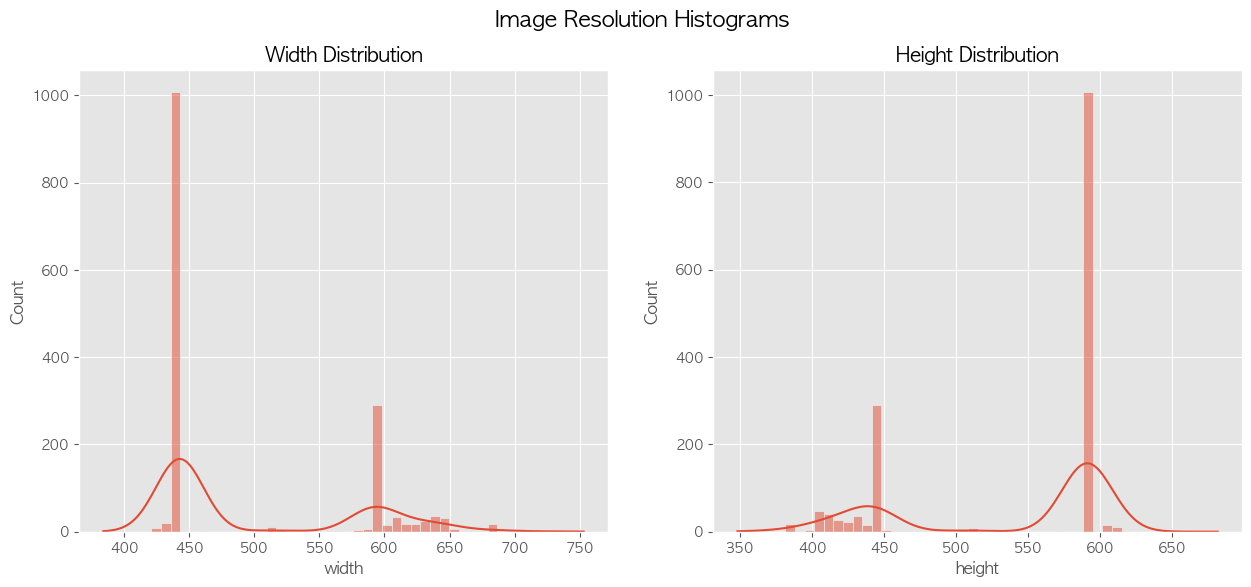

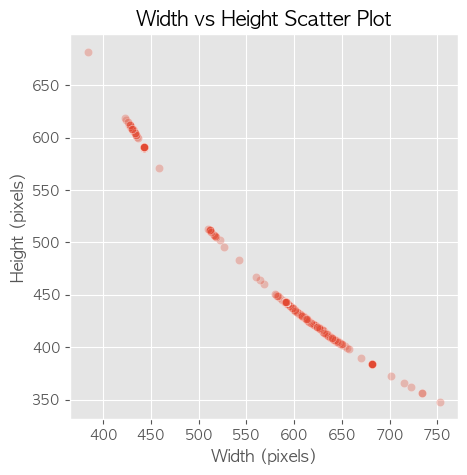

In [40]:
''' 해상도 분포 시각화 '''

# 그래프 스타일 설정
plt.style.use('ggplot')

# 1. 가로(width)와 세로(height) 분포 히스토그램
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(resolution_df['width'], kde=True, bins=50)
plt.title('Width Distribution')

plt.subplot(1, 2, 2)
sns.histplot(resolution_df['height'], kde=True, bins=50)
plt.title('Height Distribution')

plt.suptitle('Image Resolution Histograms', fontsize=16)
plt.show()


# 2. 가로-세로 관계를 보는 스캐터 플롯
plt.figure(figsize=(5, 5))
sns.scatterplot(data=resolution_df, x='width', y='height', alpha=0.3)
plt.title('Width vs Height Scatter Plot')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)
plt.show()

해상도 주요 통계량:
             width       height  aspect_ratio
count  1570.000000  1570.000000   1570.000000
mean    497.613376   538.169427      0.970007
std      79.370316    76.074772      0.323053
min     384.000000   348.000000      0.563050
25%     443.000000   443.000000      0.749577
50%     443.000000   591.000000      0.749577
75%     591.000000   591.000000      1.334086
max     753.000000   682.000000      2.163793


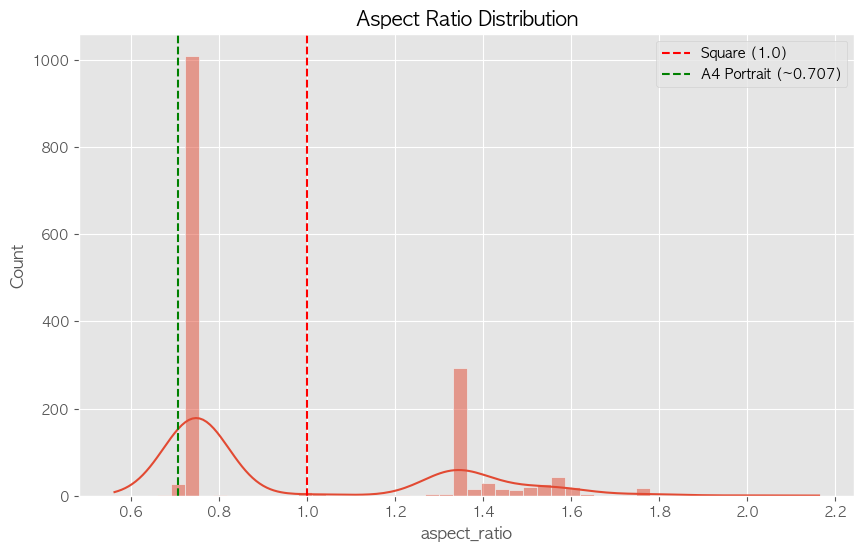

In [41]:
# 가로/세로 비율(aspect ratio) 컬럼 추가
resolution_df['aspect_ratio'] = resolution_df['width'] / resolution_df['height']

# 주요 통계량 확인
print("해상도 주요 통계량:")
print(resolution_df[['width', 'height', 'aspect_ratio']].describe())

# 가로/세로 비율 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(resolution_df['aspect_ratio'], kde=True, bins=50)
plt.title('Aspect Ratio Distribution')
plt.axvline(1.0, color='r', linestyle='--', label='Square (1.0)') # 정사각형
plt.axvline(0.707, color='g', linestyle='--', label='A4 Portrait (~0.707)') # A4 세로
plt.legend()
plt.show()

## 해상도 느낀점 


1. 대부분의 이미지가 443x591 또는 591x443 근처의 해상도를 가짐.
-> 클러스터 기반 전처리도 가능할듯

2. **가로가 긴 이미지**도 있고, **세로가 긴 이미지**도 존재함.
- 특히 상위 25%는 비율이 1.33 이상 → **A4 문서** 또는 **차량 사진**일 가능성.
- 반면 하위 25%는 약 0.74 → 신분증류, 의료 서류일 가능성.
- → **비율 정보 자체가 중요한 피처**가 될 수 있음

3. 해상도와 종횡비는 클래스 구분에 활용 가능 

- 예: ‘차량번호판’, ‘운전면허증’, ‘여권’처럼 **정형화된 이미지 구조를 가진 클래스**는 고정된 해상도 분포와 종횡비를 가질 가능성 높음.
- → width, height, aspect_ratio를 모델에 **추가적인 메타 피처로 활용** 가능함 